# Set up

In [16]:
import sys
sys.path.insert(0, '/home/workspace/mm_analysis')

from py_util import *

hdir = '/home/workspace/'
wdir = hdir + "/mm_analysis/EXP-01244"
pltdir = wdir + "/plots/"
srldir = wdir + "/objects/"

raw_adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')
adata = sc.read_h5ad(srldir + 'subclustered_adata.h5ad')
# adata = sc.read_h5ad(srldir + 'processed_adata.h5ad')
# adata = adata[adata.obs['harmony'] == 'no harmony']

# Loading BMMC celltype reference

In [32]:
# label_ref = pd.read_csv("~/TissDiss/Cell Labeling_MM - Aishwarya's Healthy BM labels.csv")
# label_ref = label_ref.iloc[:35, :5]
# label_ref.to_csv("~/TissDiss/bm_cell_label_reference.csv")
label_ref = pd.read_csv("~/mm_analysis/bm_cell_label_reference.csv")

marker_genes = {
    name: genes.split(", ")
    for name, genes in zip(label_ref.iloc[:, 5], label_ref.iloc[:, 3])
}

gene_list = list(set([gene for genes in marker_genes.values() for gene in genes]))
missing_genes = [gene for gene in gene_list if gene not in adata.var.gene_ids]

marker_genes = {
    cell_type: [gene for gene in genes if gene not in missing_genes]
    for cell_type, genes in marker_genes.items()
}

# Checking which ADT protein names are already present in the RNA gene list

- The BMMC cell type reference sheet contains gene and protein markers, but not all of the protein markers are present in the gene markers list.
- Need to find the gene names for all the protein names that aren't already present in the adata gene list

In [16]:
adt_genes = {
    name: [gene.split(' (')[0] for gene in str(adt).split(", ")]
    for name, adt in zip(label_ref.iloc[:, 5], label_ref.iloc[:, 4])
}

adt_ls = list(set([gene for genes in adt_genes.values() for gene in genes]))

adt_presence = {
    gene: gene in adata.var.gene_ids
    for gene in adt_ls
}

{
    gene: value
    for gene, value in adt_presence.items() if value == False
}

adt_presence

{'CD36': True,
 'CD25': False,
 'CD20': False,
 'CD141': False,
 'CD56': False,
 'CD19': True,
 'IgH': False,
 'CD14': True,
 'CD69': True,
 'CD11c': False,
 'CX3CR1': True,
 'CD197': False,
 'CD8': False,
 'CD10': False,
 'CD3': False,
 'CD24': True,
 'CD38': True,
 'CD22': True,
 'CD11b': False,
 'CD71': False,
 'HLA-DR': False,
 'CD16': False,
 'CD164': True,
 'CD45RO': False,
 'CD27': True,
 'CD33': True,
 'CD161': False,
 'CD84': True,
 'CD123': False,
 'CD57': False,
 'CD86': True,
 'CD7': True,
 'IgD': False,
 'CD4': True,
 'CD45RA': False,
 'CD335': False,
 'CD34': True,
 'nan': False}

# Checking whether the alterative gene names are present in the RNA gene list

- The protein names that aren't present in the RNA gene list, have alternative names that are present in the gene list.

In [20]:
gene_alts = {
    'CD25': 'IL2RA',
    'CD20': 'MS4A1',
    'CD141': 'THBD',
    'CD56': 'NCAM1',
    'IgH': '',                                     # Raw adata shows multiple IgH genes ('IGHA2','IGHE','IGHA1','IGHG1','IGHG3','IGHD','IGHM')
    'CD11c': 'ITGAX',
    'CD197': 'CCR7',
    'CD8': 'CD8A',
    'CD10': 'MME',
    'CD3': ['CD3D', 'CD3E', 'CD3G', 'CD3W'],       # Tons of CD3 genes for different protein subunits
    'CD11b': 'ITGAM',
    'CD71': 'TFRC',
    'HLA-DR': '',                                  # Tons of HLA-DR genes for different protein subunits
    'CD16': 'FCGR3A',
    'CD45RO': 'PTPRC',                             # No results for CD45RO, but there are results for CD45R
    'CD161': 'KLRB1',
    'CD123': 'IL3RA',
    'CD57': 'B3GAT1',
    'IgD': '',                                     # Couldn't find in genenames or flex probe set, btu I did find IGHD "constant region of heavy chain of IgD" in genenames
    'CD45RA': '',                                  # No results for CD45RA, but there are results for CD45R
    'CD335': 'NCR1',
    'nan': ''
}

def check_genes_in_list(gene_alts, gene_list):
    results = {}
    for key, value in gene_alts.items():
        if isinstance(value, list):
            results[key] = {
                'alt_genes': value,
                'present': [gene in gene_list for gene in value]
            }
        elif value:
            results[key] = {
                'alt_genes': value,
                'present': value in gene_list
            }
        else:
            results[key] = {
                'alt_genes': '',
                'present': False
            }
    return results

# Example usage:
gene_list = ['IL2RA', 'MS4A1', 'CD3D', 'CD3E']  # Your list of genes here
results = check_genes_in_list(gene_alts, adata.var.gene_ids)

# Print results
for key, value in results.items():
    print(f"{key}: {value}")

CD25: {'alt_genes': 'IL2RA', 'present': True}
CD20: {'alt_genes': 'MS4A1', 'present': True}
CD141: {'alt_genes': 'THBD', 'present': True}
CD56: {'alt_genes': 'NCAM1', 'present': True}
IgH: {'alt_genes': '', 'present': False}
CD11c: {'alt_genes': 'ITGAX', 'present': True}
CD197: {'alt_genes': 'CCR7', 'present': True}
CD8: {'alt_genes': 'CD8A', 'present': True}
CD10: {'alt_genes': 'MME', 'present': True}
CD3: {'alt_genes': ['CD3D', 'CD3E', 'CD3G', 'CD3W'], 'present': [True, True, True, False]}
CD11b: {'alt_genes': 'ITGAM', 'present': True}
CD71: {'alt_genes': 'TFRC', 'present': True}
HLA-DR: {'alt_genes': '', 'present': False}
CD16: {'alt_genes': 'FCGR3A', 'present': True}
CD45RO: {'alt_genes': 'PTPRC', 'present': True}
CD161: {'alt_genes': 'KLRB1', 'present': True}
CD123: {'alt_genes': 'IL3RA', 'present': True}
CD57: {'alt_genes': 'B3GAT1', 'present': True}
IgD: {'alt_genes': '', 'present': False}
CD45RA: {'alt_genes': '', 'present': False}
CD335: {'alt_genes': 'NCR1', 'present': True}


# Validating updated RNA gene list with protein markers

In [21]:
label_ref = pd.read_csv("~/TissDiss/bm_cell_label_reference.csv")

marker_genes = {
    name: genes.split(", ")
    for name, genes in zip(label_ref.iloc[:, 5], label_ref.iloc[:, 3])
}

gene_list = list(set([gene for genes in marker_genes.values() for gene in genes]))
missing_genes = [gene for gene in gene_list if gene not in adata.var.gene_ids]

marker_genes = {
    cell_type: [gene for gene in genes if gene not in missing_genes]
    for cell_type, genes in marker_genes.items()
}

marker_genes

{'Effector B Cell': ['FCRL3',
  'TBX21',
  'ITGAX',
  'PDCD1',
  'ZEB2',
  'FCRL5',
  'CD27',
  'MS4A1'],
 'Memory B Cell': ['MS4A1', 'PAX5', 'AIM2', 'CD19', 'CD22', 'CD27'],
 'Naive B Cell': ['MS4A1', 'PAX5', 'CD44'],
 'Plasma B Cell': ['PRDM1', 'XBP1', 'MZB1', 'FKBP11', 'DNTT', 'JCHAIN'],
 'Precursor B Cell': ['VPREB1', 'MME', 'CD79B'],
 'Transitional B Cell': ['PAX5', 'MME', 'CD19', 'CD24', 'CD38', 'MME'],
 'AXL+SIGLEC6+ Dendritic Cell': ['AXL', 'CD86', 'SIGLEC6', 'CLEC4C'],
 'c1 Dendritic Cell': ['CLEC9A', 'XCR1', 'THBD'],
 'c2 Dendritic Cell': ['ITGAX', 'CLEC10A', 'FLT3', 'CD14'],
 'Plasmacytoid Dendritic Cell': ['TCF4', 'IRF8', 'SERPINF1', 'IL3RA'],
 'CD14+ Monocyte': ['S100A9',
  'CCR2',
  'CD14',
  'FGR',
  'ITGAX',
  'CD34',
  'NCAM1',
  'ITGAM',
  'FCGR3A'],
 'CD16+ Monocyte': ['FCGR3A', 'IRF8', 'LY86', 'LST1', 'CD34', 'CD14'],
 'Intermediate Monocyte': ['CCR5', 'FCGR3A', 'CD14', 'CD86'],
 'CD56 Bright Natural Killer Cell': ['TYROBP',
  'KLRB1',
  'KLRF1',
  'IL7R',
  'AREG',

# Marker gene expression dotplot

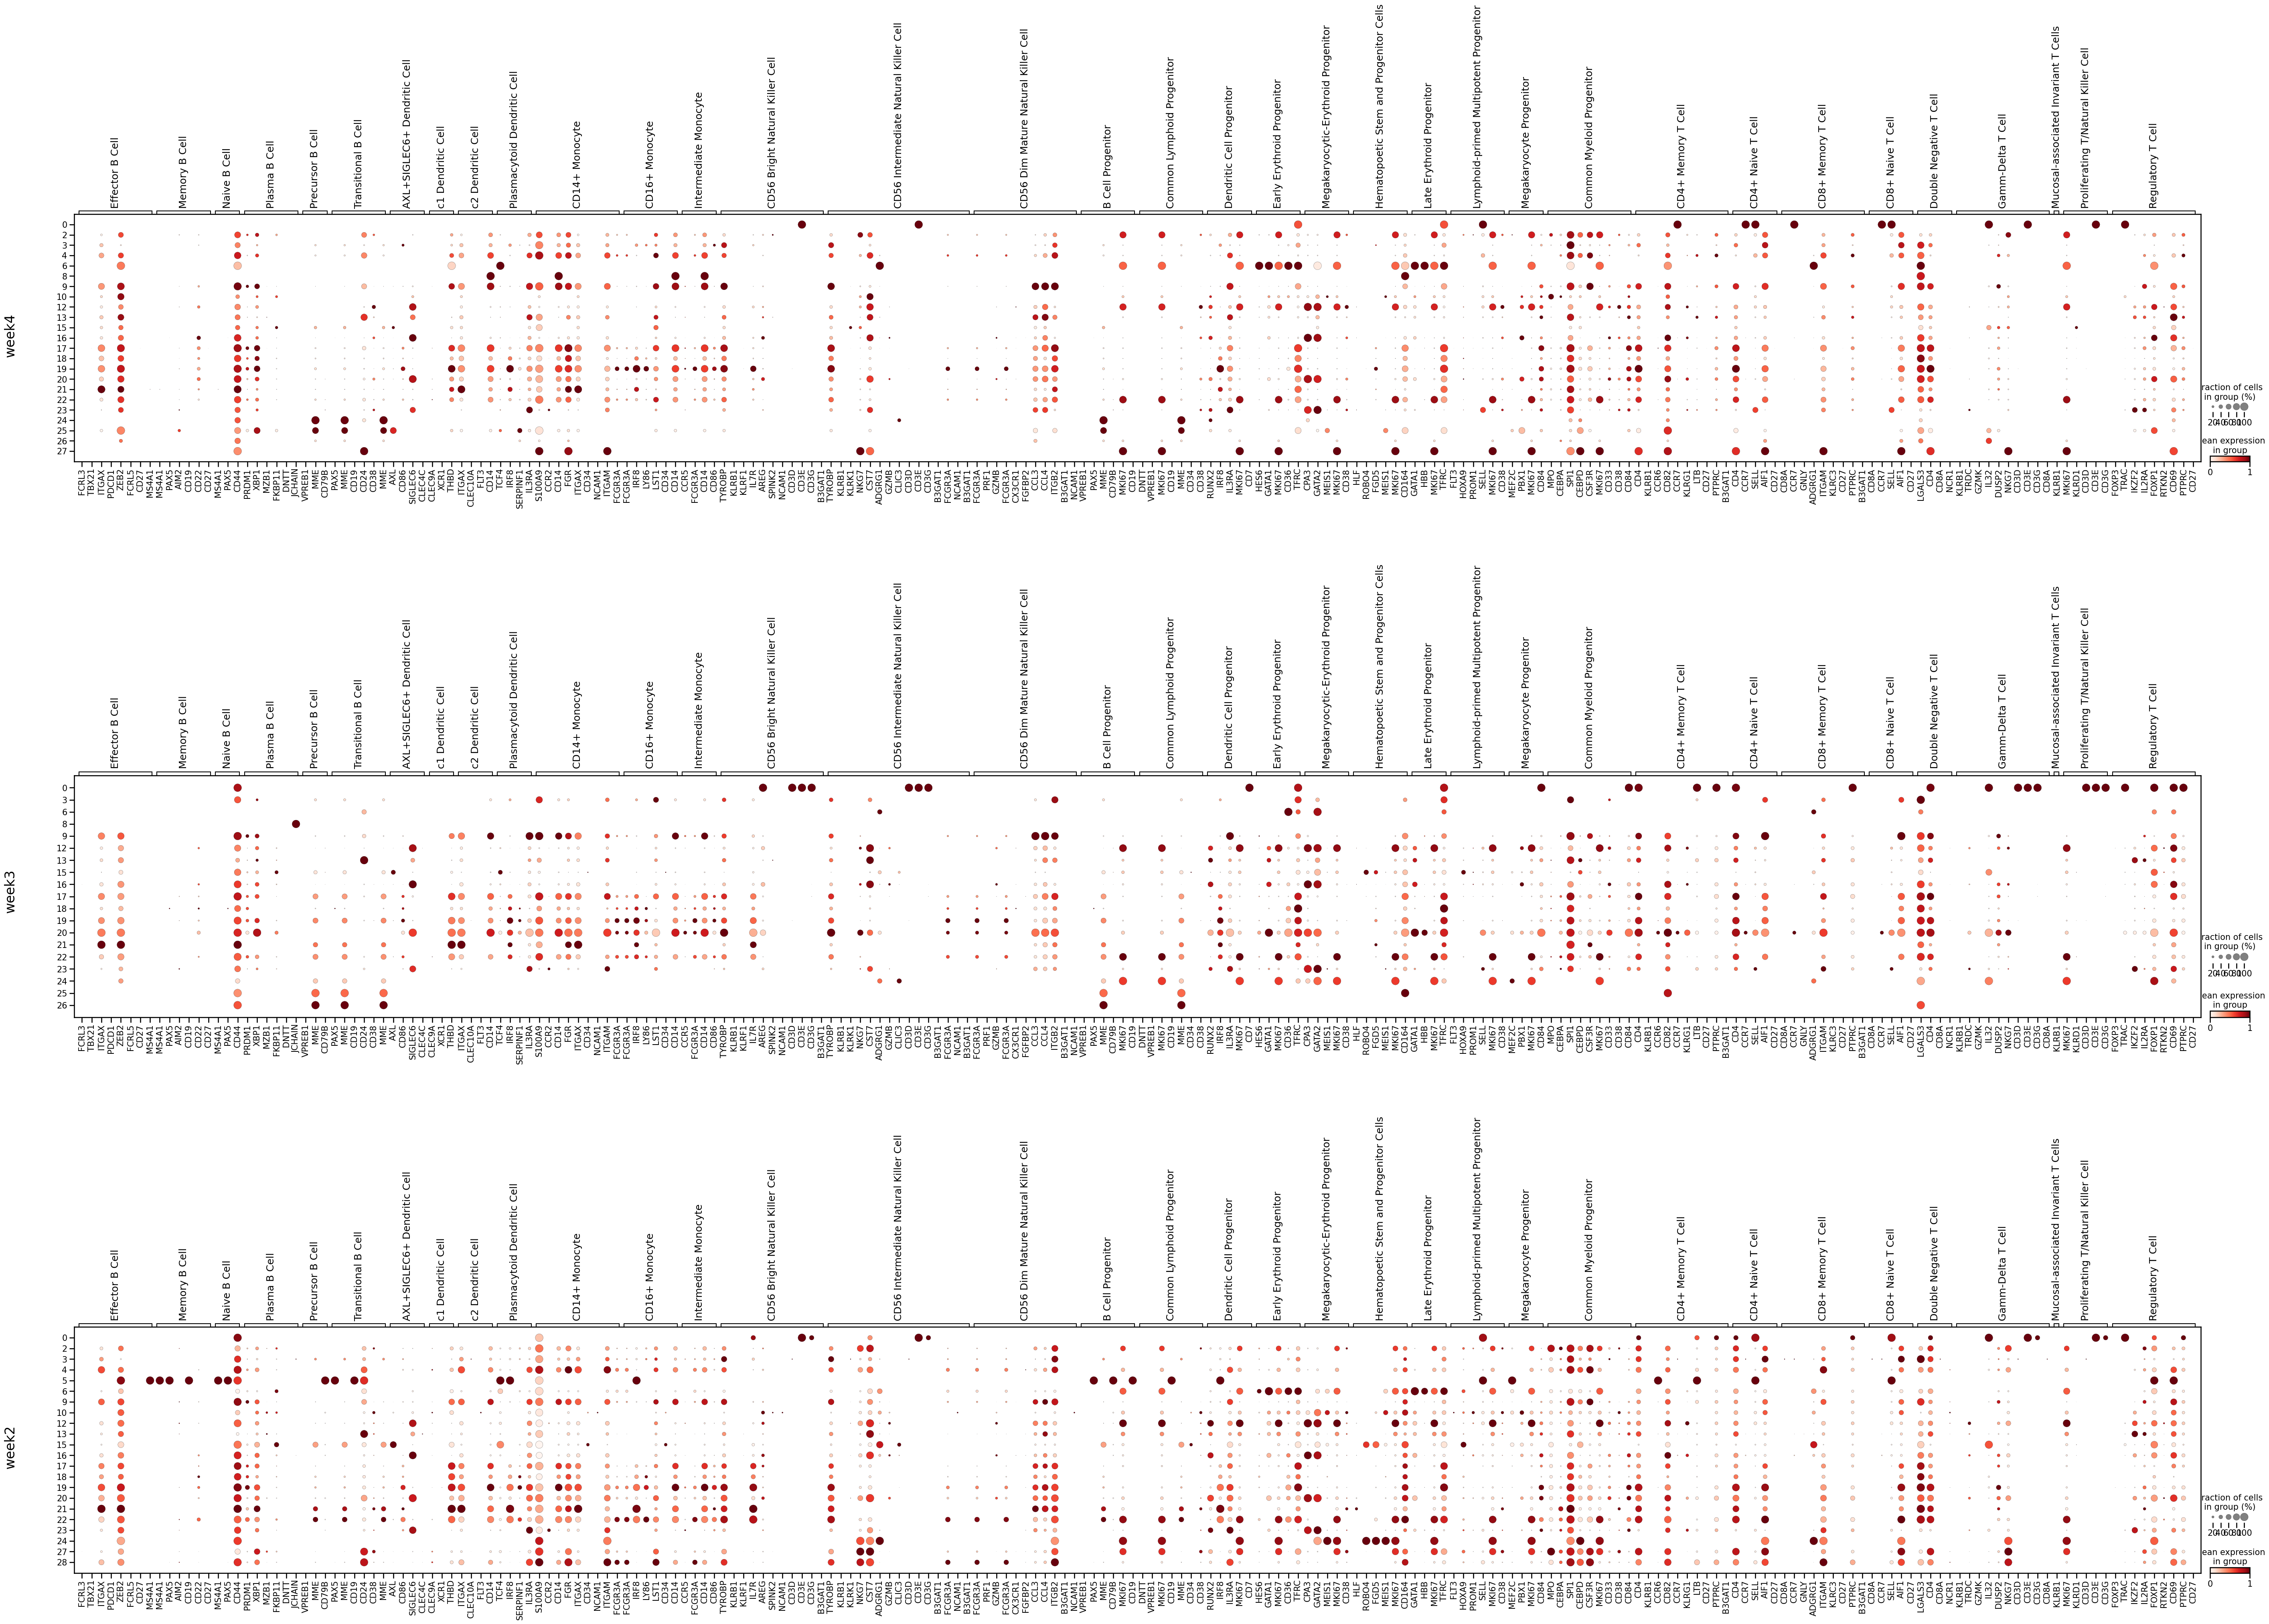

In [27]:
adatas = {
    name: adata[adata.obs['sample_type'] == name].copy()
    for name in adata.obs['sample_type'].unique() if name not in ['bm', 'msc']
}

fig, ax = plt.subplots(len(adatas), figsize=(70, 15*len(adatas)), gridspec_kw={"hspace": 1})

for i, (name, data) in enumerate(adatas.items()):
    sc.pl.dotplot(
        data,
        marker_genes,
        groupby="leiden",
        standard_scale="var",
        show=False,
        ax=ax[i]
    )

    bbox = ax[i].get_position()
    y_center = bbox.y0 + bbox.height/2.2
    
    fig.text(0.1, y_center, name, rotation=90, va='center', fontsize=24)

# Celltypist Annotation

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 2407 cells and 18023 genes
🔗 Matching reference genes in the model
🧬 6975 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 2407 cells and 18023 genes
🔗 Matching reference genes in the model
🧬 6975 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clusteri

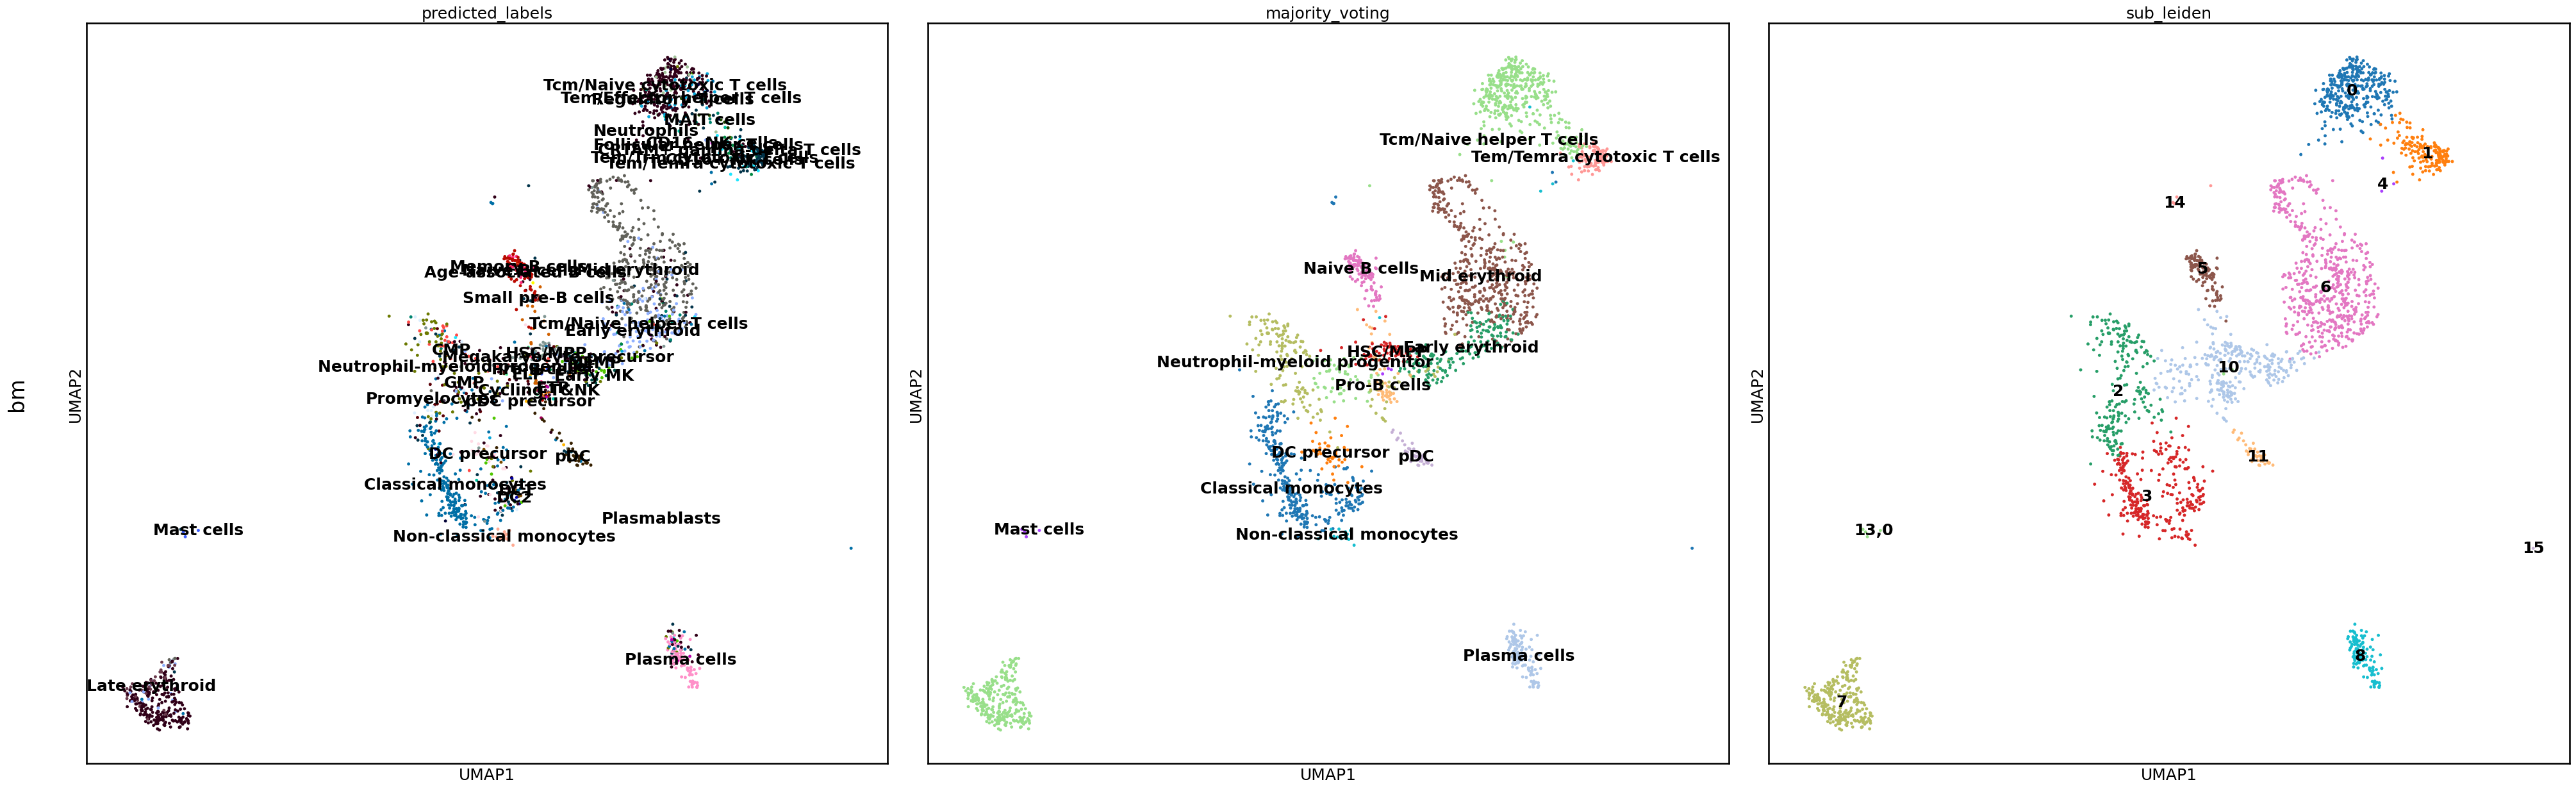

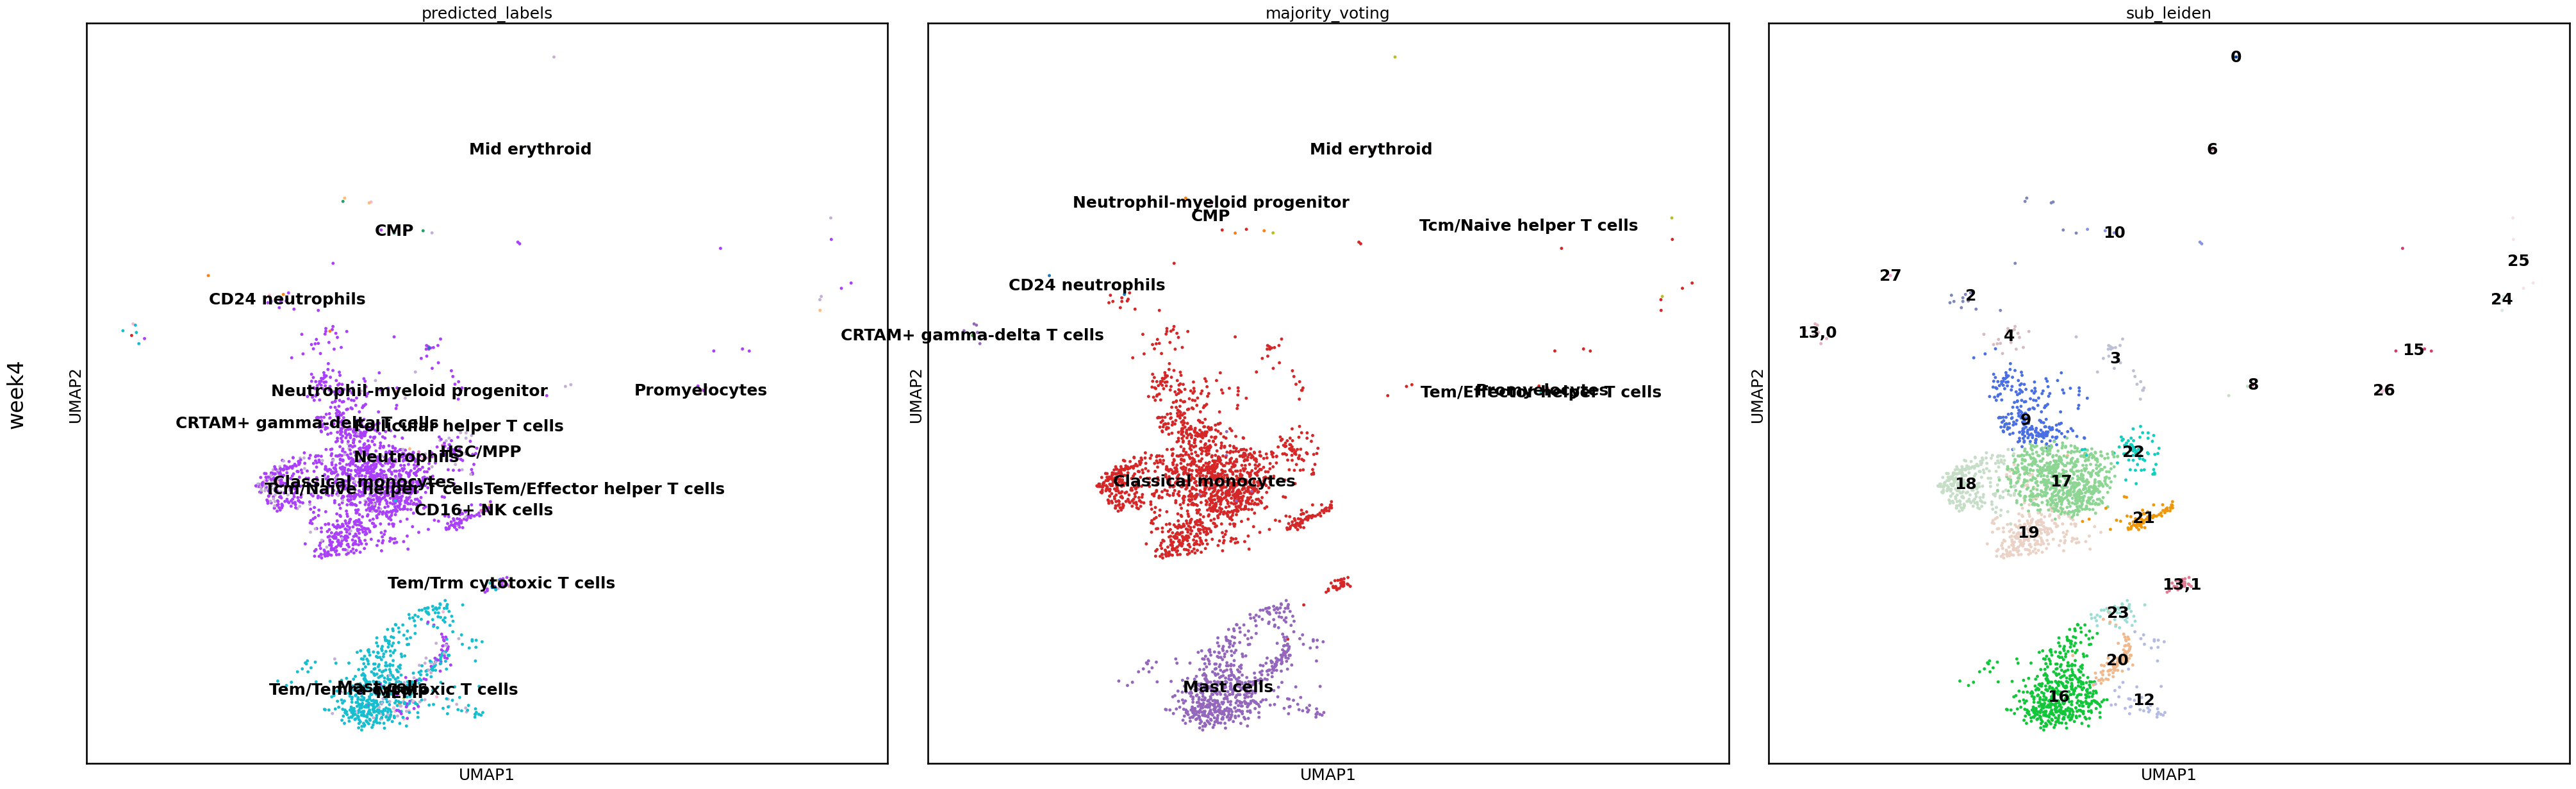

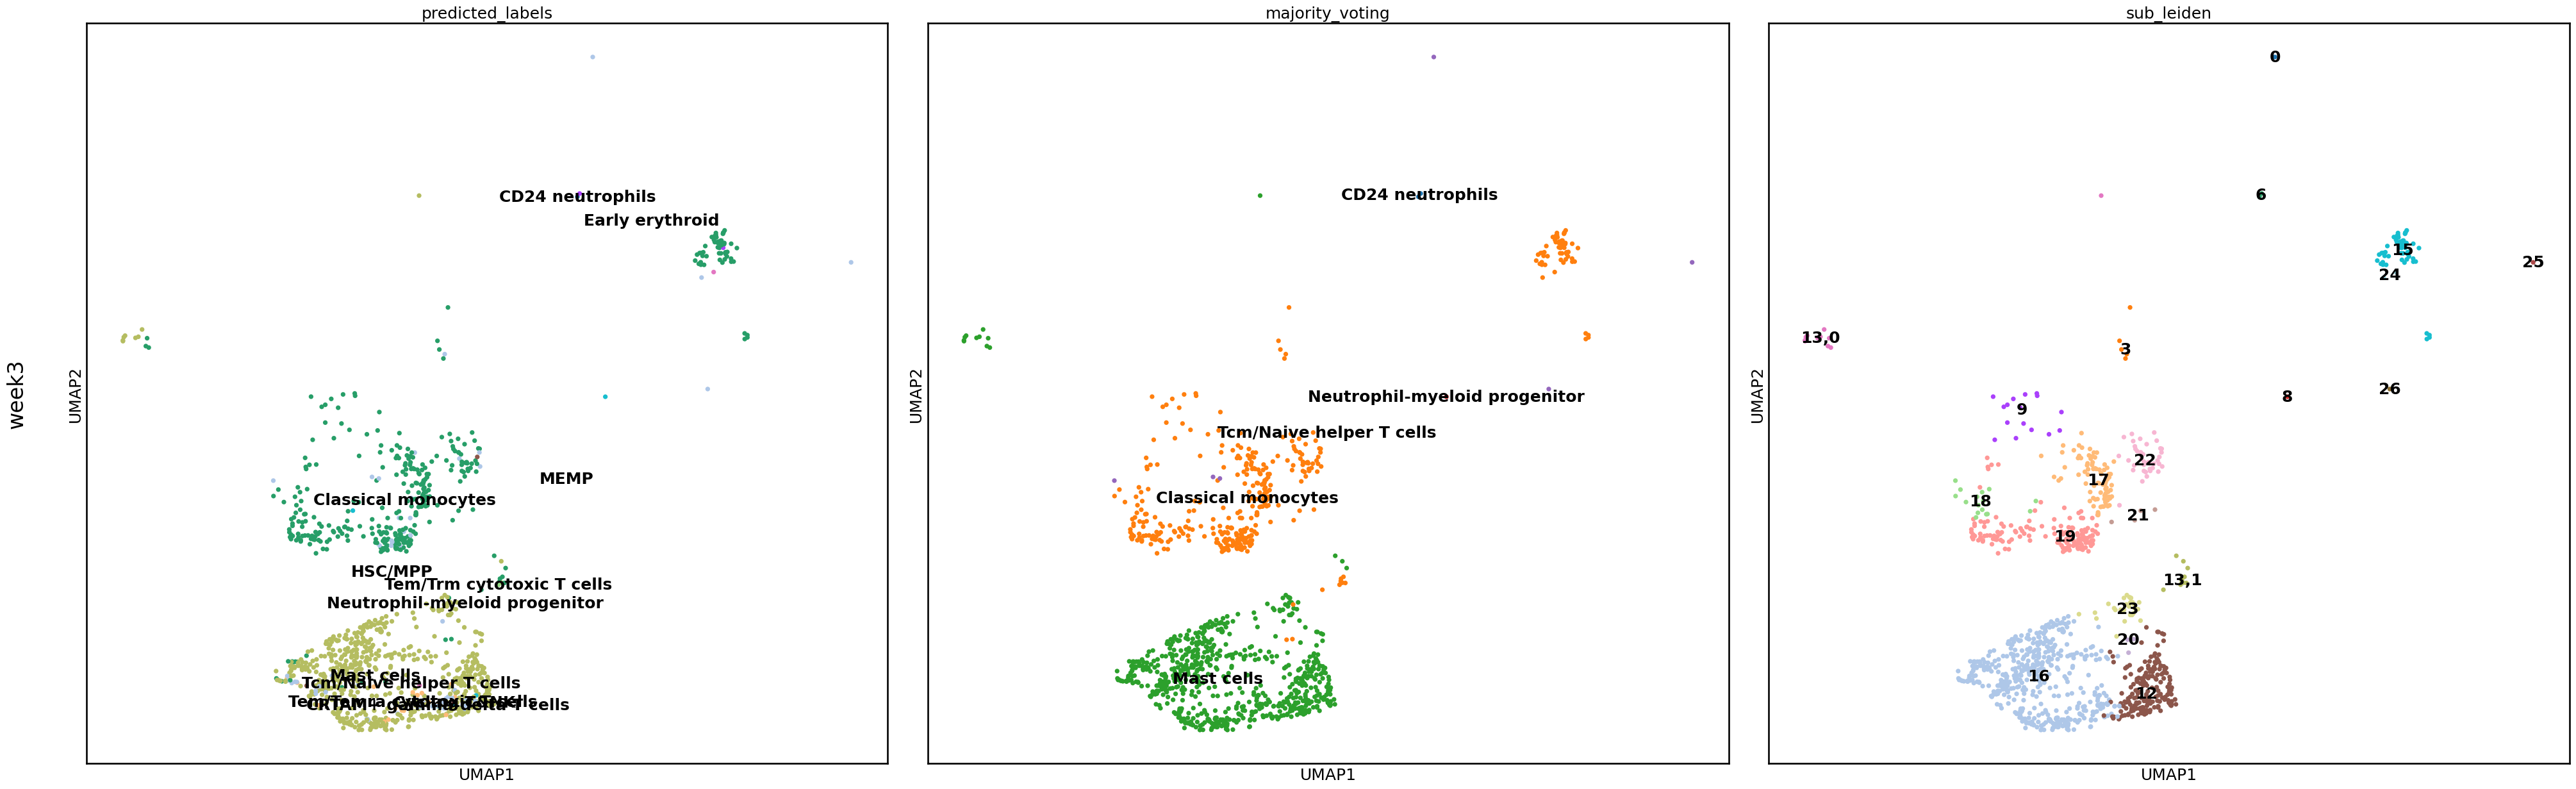

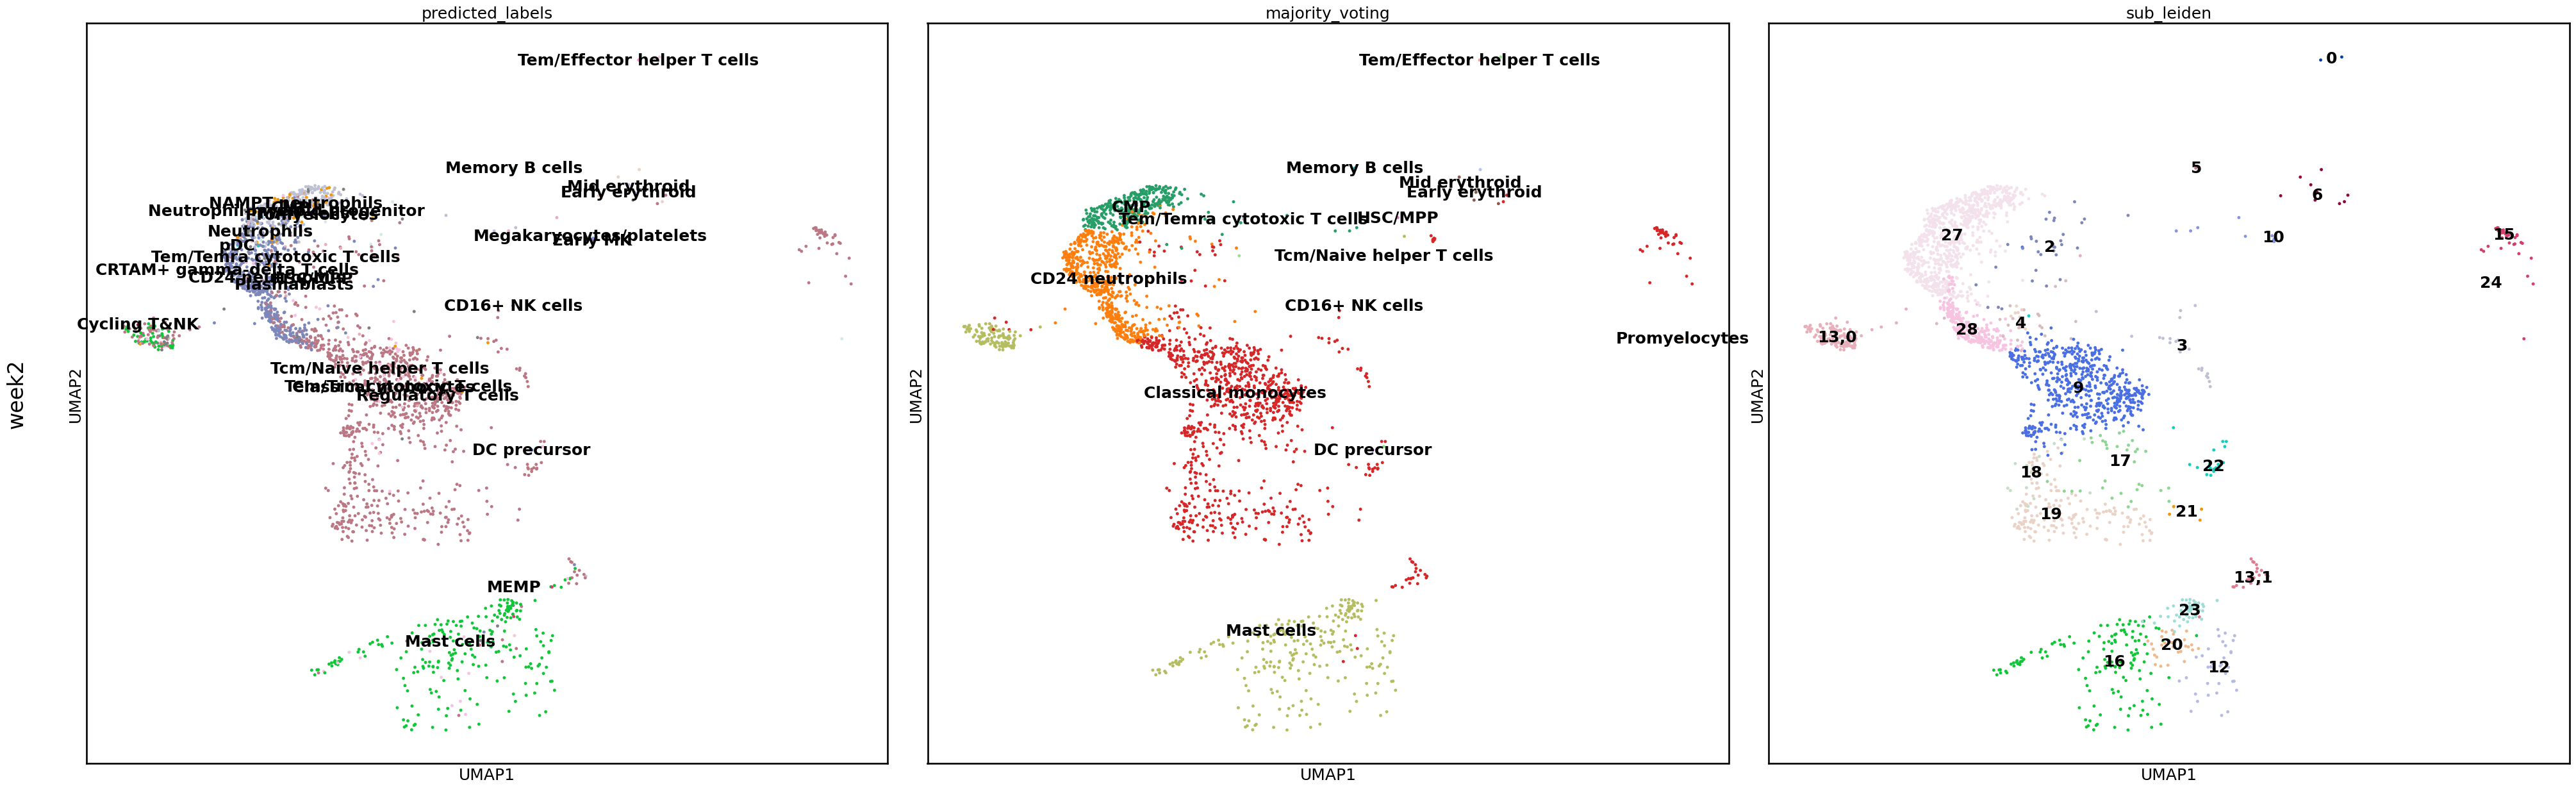

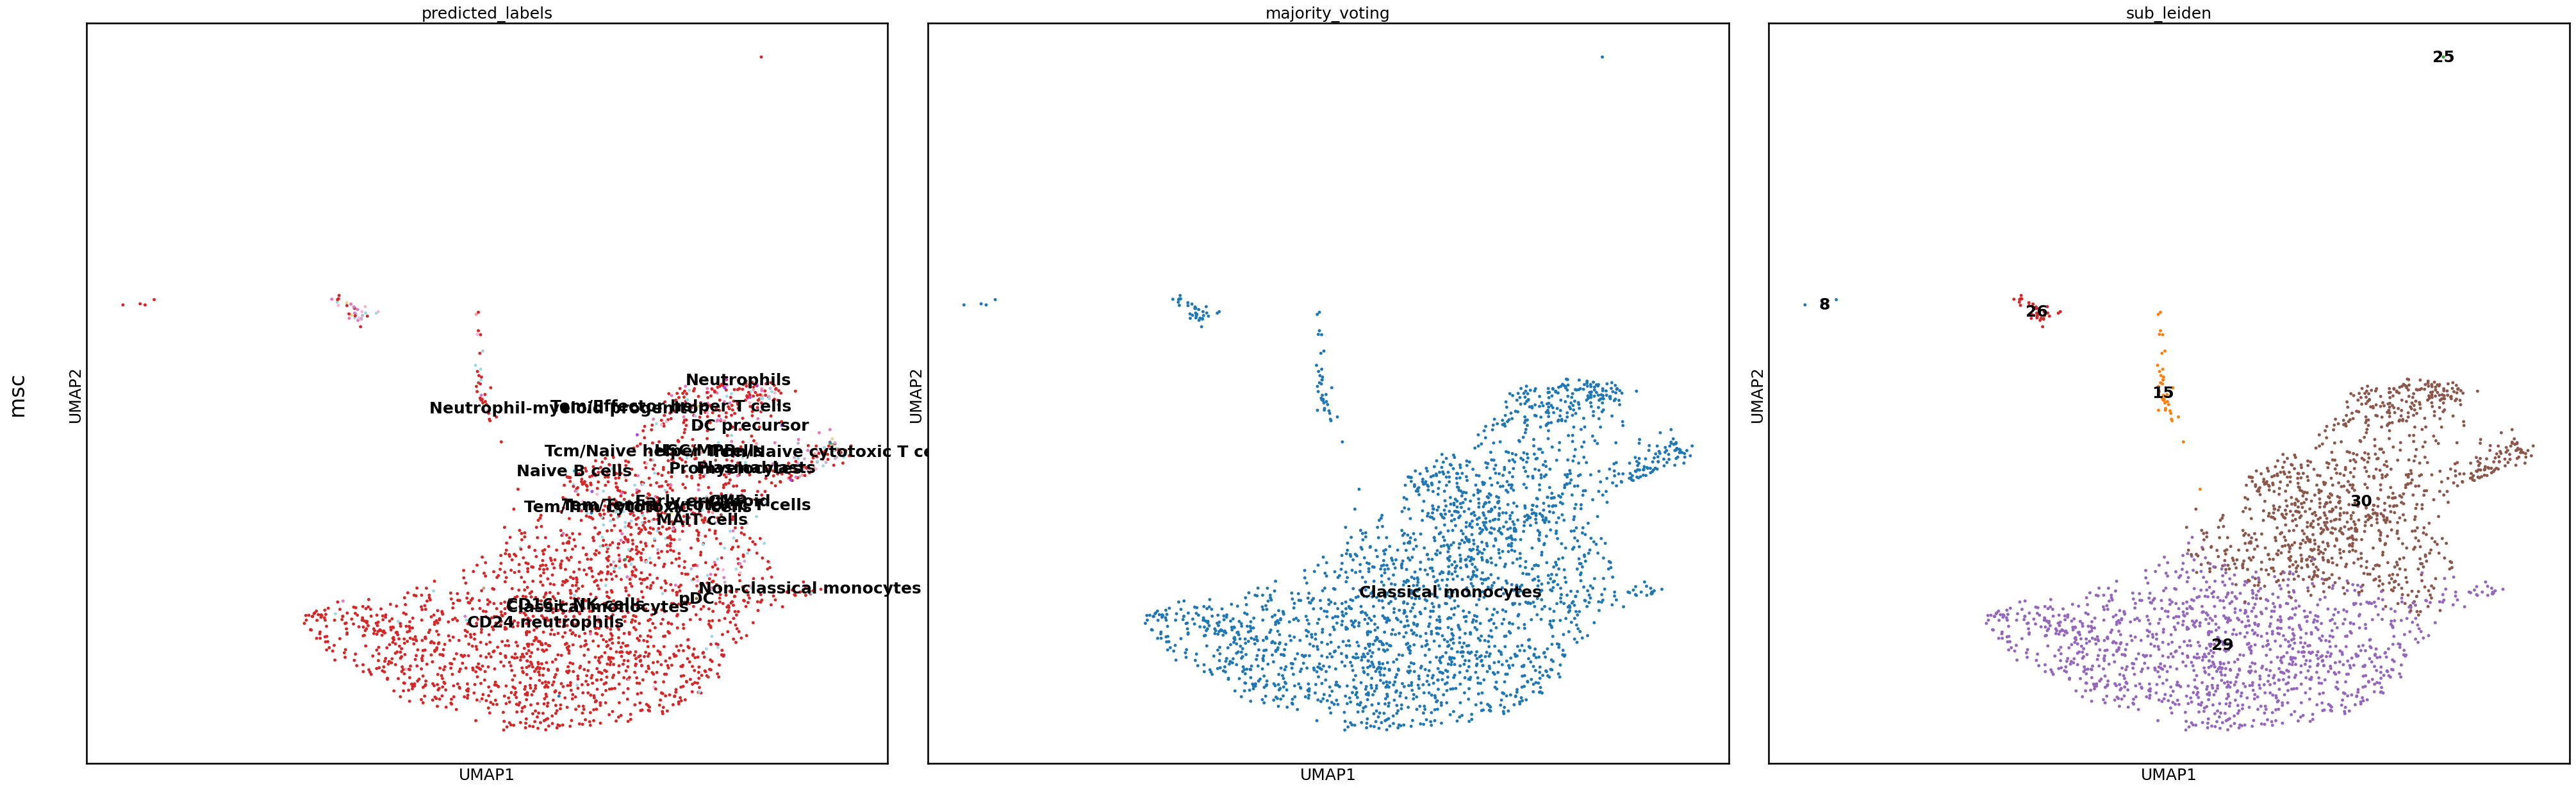

In [37]:
adatas = {
    name: adata[adata.obs['sample_type'] == name].copy()
    for name in adata.obs['sample_type'].unique()
}

model = models.Model.load(model = os.path.join(wdir, 'Adult_Human_Bone_marrow.pkl'))

for name, data in adatas.items():
    predictions = celltypist.annotate(data, model = model, majority_voting = True)
    data = predictions.to_adata()
    fig, ax = plt.subplots(1, 3, figsize=(50, 15), gridspec_kw={'wspace': 0.05})
    sc.pl.umap(data, color = ['predicted_labels'], legend_loc = 'on data', show=False, ax=ax[0])
    sc.pl.umap(data, color = ['majority_voting'], legend_loc = 'on data', show=False, ax=ax[1])
    sc.pl.umap(data, color = ['sub_leiden'], legend_loc = 'on data', show=False, ax=ax[2])
    bbox = ax[0].get_position()
    y_center = bbox.y0 + bbox.height/2
    fig.text(0.1, y_center, name, rotation=90, va='center', fontsize=24)

# Celltyping Reprocessed Individual Samples